### Step 1 of working with all the data/models now that we've got it. Specifically cleaning things up a bit and feeding the data into the model to make a catalog of true colors/parameters to compare to later once we have some "observed" data (see following notebooks).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as fits
import glob
import os
from lsst.sims.photUtils import Sed, Bandpass
from sklearn.neighbors import KDTree

In [2]:
plt.style.use('ggplot')

In [3]:
# our fake data:

with np.load('model_atm_mags.npz') as nump_zip:
    model_atm_mags = nump_zip['model_atm_mags']

In [4]:
# LSST sims fake data:

temp = np.load('stars_from_catsim.npz')
catsim_data = temp['from_catsim'].copy()
temp.close()

In [9]:
np.where(catsim_data['metallicity'] < -900)[0].size, catsim_data.size

(5374, 127426)

In [10]:
# ok, so 5k of the 127k have something that looks like a mask value of -999. Make a note to ask Scott what is up with that,
# but we'll just cut those for now.

catsim_data = catsim_data[np.where(catsim_data['metallicity'] > -900)]

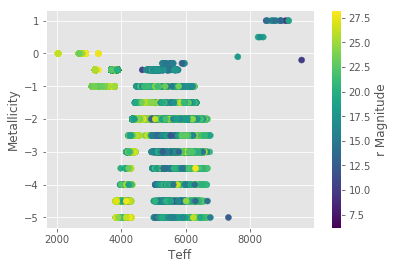

In [11]:
plt.scatter(catsim_data['teff'], catsim_data['metallicity'], c=catsim_data['rmag'])
cb = plt.colorbar()
cb.set_label('r Magnitude')
plt.xlabel('Teff')
plt.ylabel('Metallicity');

In [13]:
# I'm a little confused, those seem like amazingly low metallicity values for a lot of stars. 
# We'll go ahead and treat all of those like the minimum metallicity in our models.

In [13]:
# Now to match the catsim properties up to our model properties

# normalize all the parameters (our model fake data):

temp_norm = np.max(model_atm_mags['Teff'])
met_norm = np.max(model_atm_mags['log_Z'] ) - np.min(model_atm_mags['log_Z'])
logg_norm = np.max(model_atm_mags['gravity'] ) - np.min(model_atm_mags['gravity'])

model_X = np.array([model_atm_mags['Teff']/temp_norm,
                       model_atm_mags['log_Z']/met_norm,
                       model_atm_mags['gravity']/logg_norm]).T

model_kd_tree = KDTree(model_X)

In [14]:
# now to lookup the closest model index for each catsim star
catsim_vals = np.array([catsim_data['teff']/temp_norm,
              catsim_data['metallicity']/met_norm,
              catsim_data['logg']/logg_norm]).T
dist, indx_match = model_kd_tree.query(catsim_vals, k=1)

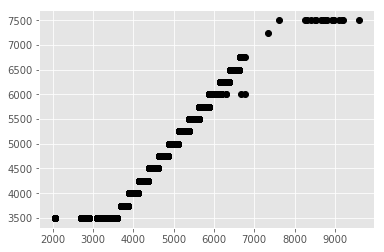

In [15]:
# check that we did kinda match things up in a reasonable way.
plt.plot(catsim_data['teff'], model_atm_mags['Teff'][indx_match], 'ko');

In [17]:
# Let's construct a realistic catalog of stars with all the info from the model atmospheres
mag_cols = ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861', 'u',
            'g', 'r', 'i', 'z', 'y']

In [18]:
truth_catalog = model_atm_mags[indx_match.ravel()]

In [19]:
dist_modulus = truth_catalog['r'] - catsim_data['rmag']

In [20]:
dist_modulus

array([-63.15321237, -61.06722329, -56.95835237, ..., -53.22021762,
       -58.89073942, -54.05242832])

In [21]:
# confirming what all's in truth_catalog:

truth_catalog.dtype

dtype([('Teff', '<f8'), ('log_Z', '<f8'), ('gravity', '<f8'), ('F378', '<f8'), ('F395', '<f8'), ('F410', '<f8'), ('F430', '<f8'), ('F515', '<f8'), ('F660', '<f8'), ('F861', '<f8'), ('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('y', '<f8')])

In [22]:
for mag_col in mag_cols:
    truth_catalog[mag_col] -= dist_modulus

In [23]:
np.savez('truth_catalog.npz', truth_catalog=truth_catalog)